# Plot model fit comparisons for simulation analysis 2

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mindstorm import statplot
from cfr import framework
from cfr import figures

fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

## Load model fits

In [5]:
# restricted models
fixed, model_names = framework.generate_restricted_models()
models = [f'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-{f.replace("=", "")}' for f in fixed]

# model from sim1
models.insert(0, 'cmrs_fcf-loc-cat-use')
model_names.insert(0, 'ICD')

# unrestricted model
models.insert(0, 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec')
model_names.insert(0, 'UR')

# Morton Polyn 2016 model
models.append('cmrs_fcf-loc_ff-cat-use')
model_names.append('MP16')

res = framework.read_model_xvals(fit_dir, models, model_names)
res.groupby('model')['logl_test_list'].mean().sort_values()

subs_names = ['ICD', 'UR', 'RC-RD', 'EC-ED-RC-RD', 'MP16']
subs_models = [models[model_names.index(m)] for m in subs_names]
subs_labels = ['DCMR', 'DCMR-Variable', 'DCMR-Restricted', 'DCMR-NoSemDrift', 'CMR MP16']

## Plot model cross-validation performance

LINO NOT subset; don't know how to subset; dropped


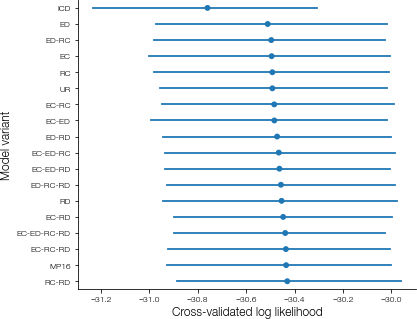

In [6]:
# plot cross-validation log-likelihood with within-subject error
res['deviation'] = figures.remove_subject_variance(
    res, 'logl_test_list', 'subject'
)
res['mean_deviation'] = res.groupby('model')['deviation'].transform('mean')
res_sorted = res.sort_values('mean_deviation').reset_index()
g = sns.catplot(
    data=res_sorted, 
    x='deviation', 
    y='model', 
    kind='point', 
    join=False, 
    aspect=1.3, 
    height=4.5,
)
g.set(xlabel='Cross-validated log likelihood', ylabel='Model variant')
g.savefig(fig_dir / 'model_comp_xval_full.pdf');

LINO NOT subset; don't know how to subset; dropped


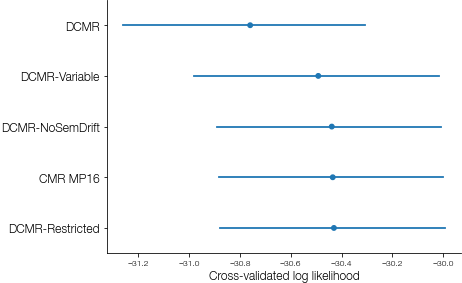

In [11]:
# plot cross-validation log-likelihood with within-subject error
subs_mapping = dict(zip(subs_names, subs_labels))
sub = res.loc[subs_names].rename(index=subs_mapping)
sub['deviation'] = figures.remove_subject_variance(
    sub, 'logl_test_list', 'subject'
)
sub['mean_deviation'] = sub.groupby('model')['deviation'].transform('mean')
res_sorted = sub.sort_values('mean_deviation').reset_index()
g = sns.catplot(
    data=res_sorted, 
    x='deviation', 
    y='model', 
    kind='point', 
    join=False, 
    aspect=1.57, 
    height=4,
)
ax = g.axes[0, 0]
ax.tick_params(axis='y', labelsize='large')
g.set(xlabel='Cross-validated log likelihood', ylabel='')
g.savefig(fig_dir / 'model_comp_xval_subset.pdf');

## Plot best-fitting B parameters by sublayer

In [5]:
dark = sns.color_palette(
    'ch:start=1, rot=1.5, light=.7, dark=.3, gamma=1, hue=.5'
)
dark

[(0.7689335648950519, 0.6824396172757954, 0.6240123846554909),
 (0.7250187127782463, 0.5677430873950093, 0.6103083104698684),
 (0.623013021104788, 0.4855809829815538, 0.6161810850461853),
 (0.464634733019296, 0.4332443294049108, 0.5801730795425324),
 (0.31355069957273196, 0.3965359745123169, 0.4760973803152319),
 (0.2050147315167219, 0.34168808481661433, 0.31762490490999895)]

In [6]:
light = sns.color_palette(
    'ch:start=1, rot=1.5, light=.7, dark=.3, gamma=.5, hue=1'
)
light

[(0.9248203983802259, 0.8124754066629261, 0.7365856230946308),
 (0.9370151046580671, 0.7134152392755648, 0.773930517001042),
 (0.8638347057562072, 0.6485629096614572, 0.8531332480304541),
 (0.6875944308206159, 0.6323388125763083, 0.8909732355818533),
 (0.4826946089121227, 0.6491392670198295, 0.8087166257388984),
 (0.325484389760949, 0.649366831333291, 0.5923429764853889)]

LINO NOT subset; don't know how to subset; dropped


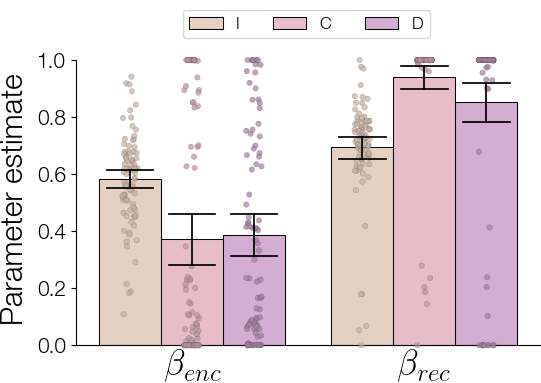

In [7]:
B_names = [
    'B_enc_loc',
    'B_enc_cat',
    'B_enc_use',
    'B_rec_loc',
    'B_rec_cat',
    'B_rec_use',
]
B_labels = [
    r'$\beta_\mathrm{enc}^{I}$',
    r'$\beta_\mathrm{enc}^{C}$',
    r'$\beta_\mathrm{enc}^{D}$',
    r'$\beta_\mathrm{rec}^{I}$',
    r'$\beta_\mathrm{rec}^{C}$',
    r'$\beta_\mathrm{rec}^{D}$',
]
B_subset = pd.melt(
    res.loc['UR', B_names].reset_index(),
    id_vars='subject', 
    value_vars=B_names,
    var_name='parameter',
    value_name='value',
)
B_subset['phase'] = B_subset['parameter'].map(
    {
        'B_enc_loc': 'enc',
        'B_enc_cat': 'enc',
        'B_enc_use': 'enc',
        'B_rec_loc': 'rec',
        'B_rec_cat': 'rec',
        'B_rec_use': 'rec',
    }
)
B_subset['sublayer'] = B_subset['parameter'].map(
    {
        'B_enc_loc': 'I',
        'B_enc_cat': 'C',
        'B_enc_use': 'D',
        'B_rec_loc': 'I',
        'B_rec_cat': 'C',
        'B_rec_use': 'D',
    }
)
fig, ax = plt.subplots(figsize=(6, 4))
statplot.plot_swarm_bar(
    B_subset,
    x='phase',
    y='value',
    hue='sublayer',
    point_kind='strip',
    light=light,
    dark=dark,
    dodge=True,
    bar_kws={'capsize': 0.2, 'clip_on': False},
    point_kws={'size': 4},
    legend=False,
    ax=ax,
)
ax.set(ylim=(0, 1), ylabel='Parameter estimate')
ax.set_xticks(
    [0, 1], 
    [r'$\beta_{enc}$', r'$\beta_{rec}$'], 
    usetex=True, 
    fontfamily='helvetica',
    fontsize='x-large',
)
ax.tick_params(axis='x', length=0)
ax.set(ylim=(0, 1.08), yticks=np.arange(0, 1.2, 0.2))
ax.spines['left'].set_bounds(0, 1)
fig.legend(loc=(.3375, .9), prop={'size': 12}, ncol=3)
ax.yaxis.set_label_coords(-.1, 0.475)
fig.savefig(fig_dir / 'param_B.pdf')

## Create parameter tables

In [8]:
table = figures.create_model_table(fit_dir, models, model_names, model_comp='xval')
table.to_latex(fig_dir / 'parameters2_full.tex', escape=False)
table

/var/folders/9d/zh72ny012k7bvgr427k05d8w0000gn/T/ipykernel_75232/3060590331.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(fig_dir / 'parameters2_full.tex', escape=False)


,UR,ICD,EC,ED,RC,RD,EC-ED,EC-RC,EC-RD,ED-RC,ED-RD,RC-RD,EC-ED-RC,EC-ED-RD,EC-RC-RD,ED-RC-RD,EC-ED-RC-RD,MP16
$L_{FC}$,0.15 (0.02),0.10 (0.01),0.15 (0.03),0.13 (0.02),0.15 (0.02),0.16 (0.03),0.08 (0.01),0.12 (0.02),0.12 (0.02),0.09 (0.01),0.10 (0.01),0.13 (0.02),0.08 (0.01),0.08 (0.01),0.12 (0.02),0.09 (0.01),0.08 (0.01),0.08 (0.01)
$L_{CF}$,0.14 (0.02),0.09 (0.01),0.14 (0.03),0.13 (0.02),0.14 (0.02),0.15 (0.02),0.08 (0.01),0.11 (0.02),0.11 (0.02),0.09 (0.01),0.10 (0.01),0.12 (0.02),0.08 (0.01),0.08 (0.01),0.11 (0.02),0.09 (0.01),0.08 (0.01),0.07 (0.01)
$D_{FF}$,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,0.14 (0.00)
$\phi_s$,0.07 (0.01),0.03 (0.00),0.03 (0.00),0.05 (0.00),0.07 (0.01),0.08 (0.01),0.02 (0.00),0.03 (0.00),0.03 (0.00),0.05 (0.01),0.05 (0.00),0.08 (0.01),0.02 (0.00),0.02 (0.00),0.03 (0.00),0.05 (0.00),0.02 (0.00),0.69 (0.14)
$\phi_d$,1.21 (0.16),1.84 (0.18),1.16 (0.16),1.41 (0.18),1.14 (0.15),1.19 (0.15),1.38 (0.18),1.20 (0.16),1.14 (0.16),1.44 (0.18),1.44 (0.18),1.23 (0.15),1.18 (0.16),1.24 (0.17),1.17 (0.16),1.37 (0.18),1.29 (0.17),1.57 (0.15)
$\beta_{\mathrm{enc}}$,---,0.62 (0.01),---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,0.62 (0.01)
"$\beta_{\mathrm{enc},I}$",0.58 (0.02),---,0.58 (0.02),0.60 (0.01),0.58 (0.02),0.58 (0.02),0.62 (0.01),0.60 (0.02),0.60 (0.02),0.60 (0.01),0.61 (0.01),0.58 (0.02),0.62 (0.01),0.63 (0.01),0.60 (0.02),0.60 (0.01),0.63 (0.01),---
"$\beta_{\mathrm{enc},C}$",0.37 (0.05),---,1,0.37 (0.04),0.33 (0.04),0.34 (0.04),1,1,1,0.40 (0.04),0.45 (0.04),0.39 (0.05),1,1,1,0.45 (0.04),1,---
"$\beta_{\mathrm{enc},D}$",0.39 (0.04),---,0.40 (0.04),1,0.44 (0.04),0.43 (0.04),1,0.35 (0.04),0.41 (0.04),1,1,0.42 (0.04),1,1,0.39 (0.04),1,1,---
$\beta_{\mathrm{start}}$,0.40 (0.04),0.50 (0.04),0.54 (0.04),0.52 (0.04),0.41 (0.04),0.39 (0.04),0.68 (0.03),0.58 (0.04),0.59 (0.04),0.57 (0.04),0.59 (0.04),0.42 (0.04),0.69 (0.03),0.71 (0.03),0.60 (0.04),0.60 (0.04),0.71 (0.03),0.48 (0.04)


In [9]:
table = figures.create_model_table(fit_dir, subs_models, subs_labels, model_comp='xval')
table.to_latex(fig_dir / 'parameters2.tex', escape=False)
table

/var/folders/9d/zh72ny012k7bvgr427k05d8w0000gn/T/ipykernel_75232/1785184838.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(fig_dir / 'parameters2.tex', escape=False)


,DCMR,DCMR-Variable,DCMR-Restricted,CMR MP16
$L_{FC}$,0.10 (0.01),0.15 (0.02),0.13 (0.02),0.08 (0.01)
$L_{CF}$,0.09 (0.01),0.14 (0.02),0.12 (0.02),0.07 (0.01)
$D_{FF}$,---,---,---,0.14 (0.00)
$\phi_s$,0.03 (0.00),0.07 (0.01),0.08 (0.01),0.69 (0.14)
$\phi_d$,1.84 (0.18),1.21 (0.16),1.23 (0.15),1.57 (0.15)
$\beta_{\mathrm{enc}}$,0.62 (0.01),---,---,0.62 (0.01)
"$\beta_{\mathrm{enc},I}$",---,0.58 (0.02),0.58 (0.02),---
"$\beta_{\mathrm{enc},C}$",---,0.37 (0.05),0.39 (0.05),---
"$\beta_{\mathrm{enc},D}$",---,0.39 (0.04),0.42 (0.04),---
$\beta_{\mathrm{start}}$,0.50 (0.04),0.40 (0.04),0.42 (0.04),0.48 (0.04)


In [10]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

mindstorm : 0.8.1
pandas    : 1.4.2
seaborn   : 0.11.2
psifr     : 0.8.0
numpy     : 1.21.4
cfr       : 0.1.0
matplotlib: 3.5.2

